1. One-Hot Encoding

  각 선택지에 해당하는 인덱스 원소는 1, 나머지는 0의 값을 가지도록하는 표현 방법

  원-핫 벡터의 무작위성 : 모든 클래스 간 관계를 균등하게 분배 (단어의 유사성을 구할 수 없는 단점)

2. Softmax Regression

- Multi-class Classification

  iris data

- Softmax function

  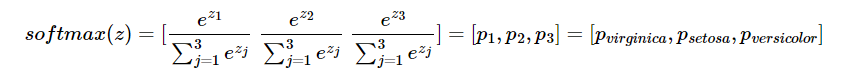

  소프트맥스 함수의 입력으로 어떻게 바꿀까? 하나의 샘플 데이터가 만약 4개의 독립변수를 가진다면 이는 모델이 4차원 벡터를 입력 받음을 의미한다. 그러나 벡터 차원이 분류하고자 하는 클래스의 개수가 3개라면 3차원 벡터로 변환되어야 한다. 이는 오차를 최소화하는 가중치 곱으로 만들 수 있다. 

  오차를 어떻게 구할까? 소프트맥스의 실제값은 원-핫 벡터이다. 실제값과 예측값 벡터의 오차를 계산하기 위해 크로스 엔트로피 함수를 사용한다. 

3. Cost function

- 크로스 엔트로피 함수

  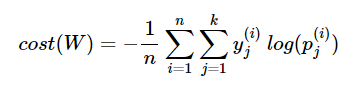

  log 1 = 0



In [4]:
# low level
import torch
import torch.nn.functional as F

z = torch.FloatTensor([1,2,3])

h = F.softmax(z,dim=0)
h

tensor([0.0900, 0.2447, 0.6652])

In [6]:
z = torch.rand(3,5,requires_grad = True)
h = F.softmax(z,dim=1) # 두번째 차원에 대해 소프트 맥스 적용
h

tensor([[0.2491, 0.1409, 0.2488, 0.2447, 0.1166],
        [0.1107, 0.2096, 0.2629, 0.2340, 0.1828],
        [0.2055, 0.2376, 0.1894, 0.2376, 0.1300]], grad_fn=<SoftmaxBackward0>)

In [8]:
y = torch.randint(5,(3,)).long()
y

tensor([3, 1, 3])

In [10]:
y_one_hot = torch.zeros_like(h)
y_one_hot.scatter_(1,y.unsqueeze(1),1) # (dim = 1에 대해서, (3,) -> (3 x 1), 숫자 1 대입) 

tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])

In [11]:
cost = (y_one_hot * -torch.log(h)).sum(dim=1).mean()
cost

tensor(1.1138, grad_fn=<MeanBackward0>)

In [ ]:
# high level

# torch.log(F.softmax(z,dim=1)) -> F.log_softmax(z,dim=1)

# (y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()
# -> (y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()
# -> F.nll_loss(F.log_softmax(z, dim=1), y)
# -> F.cross_entropy(z, y) # 크로스 엔트로피 안에는 소프트 맥스 포함

- softmax regression 구현

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [5]:
# low level
y_one_hot = torch.zeros(8,3) # 클래스 수 3
y_one_hot.scatter_(1,y_train.unsqueeze(1),1)

W = torch.zeros((4,3),requires_grad = True)
b = torch.zeros(1, requires_grad = True)

optimizer = optim.SGD([W,b],lr = 0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):
  h = F.softmax(x_train.matmul(W)+b,dim = 1)
  cost = (y_one_hot * -torch.log(h)).sum(dim=1).mean()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
      epoch, nb_epochs, cost.item()
    ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


In [6]:
# high level

nb_epochs = 1000
for epoch in range(nb_epochs + 1):
  h = F.softmax(x_train.matmul(W)+b,dim = 1)
  cost = F.cross_entropy(h,y_train)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
      epoch, nb_epochs, cost.item()
    ))

Epoch    0/1000 Cost: 0.783622
Epoch  100/1000 Cost: 0.755510
Epoch  200/1000 Cost: 0.751644
Epoch  300/1000 Cost: 0.747898
Epoch  400/1000 Cost: 0.744264
Epoch  500/1000 Cost: 0.740739
Epoch  600/1000 Cost: 0.737319
Epoch  700/1000 Cost: 0.734001
Epoch  800/1000 Cost: 0.730781
Epoch  900/1000 Cost: 0.727657
Epoch 1000/1000 Cost: 0.724623


In [ ]:
# class

class SoftmaxClassifierModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(4,3)

  def forward(self,x):
    return self.linear(x)

model = SoftmaxClassifierModel()

h = model(x_train)

- MNIST data classification

  28 x 28

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

training_epochs = 15
batch_size = 100

In [2]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(), # PyTorch Tensor
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [3]:
data_loader = DataLoader(dataset=mnist_train,
                         batch_size = batch_size,
                         shuffle = True,
                         drop_last = True) # 마지막 배치 버림(마지막 배치가 상대적으로 과대평가되는 현상 막아줌)

In [6]:
linear = nn.Linear(784,10,bias = True).to('cuda') # gpu 사용의 경우 cuda

c = nn.CrossEntropyLoss().to('cuda')
optimizer = torch.optim.SGD(linear.parameters(),lr=0.1)

In [8]:
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for X,Y in data_loader:
    X = X.view(-1,28*28).to('cuda')
    Y = Y.to('cuda')

    h = linear(X)
    cost = c(h,Y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch

  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

Epoch: 0001 cost = 0.318044871
Epoch: 0002 cost = 0.308038831
Epoch: 0003 cost = 0.300979972
Epoch: 0004 cost = 0.295532793
Epoch: 0005 cost = 0.291337281
Epoch: 0006 cost = 0.287786335
Epoch: 0007 cost = 0.284732848
Epoch: 0008 cost = 0.282314628
Epoch: 0009 cost = 0.280011475
Epoch: 0010 cost = 0.278040349
Epoch: 0011 cost = 0.276121020
Epoch: 0012 cost = 0.274740696
Epoch: 0013 cost = 0.273166537
Epoch: 0014 cost = 0.271828771
Epoch: 0015 cost = 0.270828515
